# Uploading Dataset and Training YOLO

## Install necessary libraries

In [1]:
!pip install ultralytics
!pip install roboflow # this is where we get our dataset
!pip install supervision # for trackers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

## Download the dataset (football-players-detection - roboflow)

In [ ]:
# Downloading the Dataset
# Something worth mentioning: In this dataset, goalkeepers are detected individually, like players or refrees.
# so when we train YOLO on this dataset, we can see the output consists goalkeeper class
# But! in the practice, because of small dataset, goalkeepers change identity frequently which is not desireable.
# Therefore, when we implement Tracker class, we decided to remove "goalkeep" idenenty and replace it with another "Player"

from roboflow import Roboflow
rf = Roboflow(api_key="2gYeG3vEpMC0fZOrNR26")
project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-1 in yolov5pytorch:: 100%|██████████| 1338/1338 [00:01<00:00, 891.25it/s] 


## Prepare dataset to start training (Correcting tha path and data augmentation)

In [ ]:
import shutil

shutil.move('football-players-detection-1/train',
            'football-players-detection-1/football-players-detection-1/train'
            )

shutil.move('football-players-detection-1/test',
            'football-players-detection-1/football-players-detection-1/test'
            )

shutil.move('football-players-detection-1/valid',
            'football-players-detection-1/football-players-detection-1/valid'
            )

'football-players-detection-1/football-players-detection-1/valid'

In [ ]:
import os
import cv2
import numpy as np
import random
from glob import glob

# Paths to dataset folders
dataset_path = "/content/football-players-detection-1/football-players-detection-1"
folders = ["train", "valid", "test"]

def add_noise(image):
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    return cv2.add(image, noise)

def change_brightness(image, factor):
    return cv2.convertScaleAbs(image, alpha=factor, beta=0)

# Process each folder
for folder in folders:
    image_dir = os.path.join(dataset_path, folder, "images")
    label_dir = os.path.join(dataset_path, folder, "labels")

    images = []
    for ext in ["*.jpg", "*.png", "*.jpeg"]:
        images.extend(glob(os.path.join(image_dir, ext)))

    if not images:
        print(f"No images found in {image_dir}")
        continue  # Skip this folder if no images are found

    for img_path in random.sample(images, min(20, len(images))):  # Selecting up to 20 images per folder
        img_name = os.path.basename(img_path)  # Get full file name
        img_stem = ".".join(img_name.split(".")[:-1])  # Remove the last extension only
        label_path = os.path.join(label_dir, img_stem + ".txt")

        if not os.path.exists(label_path):
            print(f"Missing label for {img_name}, skipping...")
            continue  # Skip if annotation file is missing

        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to read {img_name}, skipping...")
            continue  # Skip if the image cannot be read

        # Generate noisy version
        noisy_img = add_noise(image)
        noisy_img_name = img_stem + "_noisy." + img_name.split(".")[-1]
        cv2.imwrite(os.path.join(image_dir, noisy_img_name), noisy_img)

        # Generate brightness-adjusted version
        brightness_factor = random.uniform(0.5, 1.5)
        bright_img = change_brightness(image, brightness_factor)
        bright_img_name = img_stem + "_bright." + img_name.split(".")[-1]
        cv2.imwrite(os.path.join(image_dir, bright_img_name), bright_img)

        # Copy original label file
        noisy_label_path = os.path.join(label_dir, img_stem + "_noisy.txt")
        bright_label_path = os.path.join(label_dir, img_stem + "_bright.txt")

        with open(label_path, "r") as f:
            label_content = f.read()

        with open(noisy_label_path, "w") as f:
            f.write(label_content)

        with open(bright_label_path, "w") as f:
            f.write(label_content)

        print(f"Augmented: {img_name} -> {noisy_img_name}, {bright_img_name}")

print("Data augmentation completed.")


Augmented: 121364_9_7_png.rf.c9f26b68957b71159541823c60d05c30.jpg -> 121364_9_7_png.rf.c9f26b68957b71159541823c60d05c30_noisy.jpg, 121364_9_7_png.rf.c9f26b68957b71159541823c60d05c30_bright.jpg
Augmented: 798b45_7_3_png.rf.3bc218b7996402acb54e4198d96b3b68.jpg -> 798b45_7_3_png.rf.3bc218b7996402acb54e4198d96b3b68_noisy.jpg, 798b45_7_3_png.rf.3bc218b7996402acb54e4198d96b3b68_bright.jpg
Augmented: 08fd33_6_2_png.rf.7218277c9f313c22dd2d014e2f5d0cc3.jpg -> 08fd33_6_2_png.rf.7218277c9f313c22dd2d014e2f5d0cc3_noisy.jpg, 08fd33_6_2_png.rf.7218277c9f313c22dd2d014e2f5d0cc3_bright.jpg
Augmented: 4b770a_3_2_png.rf.494474c95db58f028f83ea8e27ae72b3.jpg -> 4b770a_3_2_png.rf.494474c95db58f028f83ea8e27ae72b3_noisy.jpg, 4b770a_3_2_png.rf.494474c95db58f028f83ea8e27ae72b3_bright.jpg
Augmented: 08fd33_6_6_png.rf.0aa29711743c98b379623700a2708f28.jpg -> 08fd33_6_6_png.rf.0aa29711743c98b379623700a2708f28_noisy.jpg, 08fd33_6_6_png.rf.0aa29711743c98b379623700a2708f28_bright.jpg
Augmented: 798b45_3_2_png.rf.4c5d93

## Train YOLO

In [ ]:
# Training
!yolo task=detect mode=train model=yolov5s6u.pt data = {dataset.location}/'data.yaml' epochs = 200 imgsz = 1280

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 29.6M/29.6M [00:00<00:00, 192MB/s]
Ultralytics 8.3.70 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5s6u.pt, data=/content/football-players-detection-1/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val,

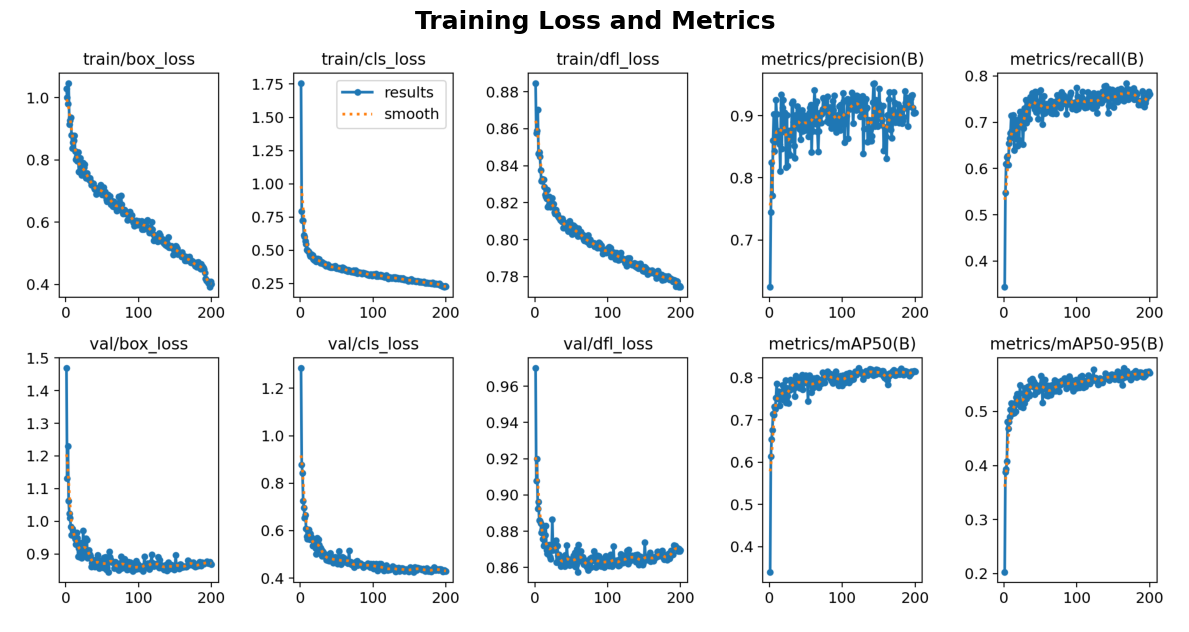

In [ ]:
# Plot Loss durining training
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/runs/detect/train/results.png')
plt.figure(figsize=(12, 8))  # Increase the figure size
plt.imshow(img)
plt.axis('off')  # Remove axis for a cleaner look
plt.title('Training Loss and Metrics', fontsize=18, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

# Testing our model on a video from Bundesliga!

In [2]:
!git clone https://github.com/Ahms9731/Project_Phase2.git

Cloning into 'Project_Phase2'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 11 (delta 0), reused 2 (delta 0), pack-reused 9 (from 2)
Receiving objects: 100% (11/11), 48.10 MiB | 12.24 MiB/s, done.


In [3]:
from ultralytics import YOLO
yolo_path = '/content/Project_Phase2/Models/yolo_best_model.pt'
model = YOLO(yolo_path)

# If you wanna test it yourself, upload the video in colab local directory and replace its path here:
test_video_path = '/content/Project_Phase2/Test Videos/test_video_1.mp4'
results = model.predict(test_video_path,save=True)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/750) /content/Project_Phase2/Test Videos/test_video_1.mp4: 768x1280 1 ball, 1 goalkeeper, 21 players, 3 referees, 75.2ms
video

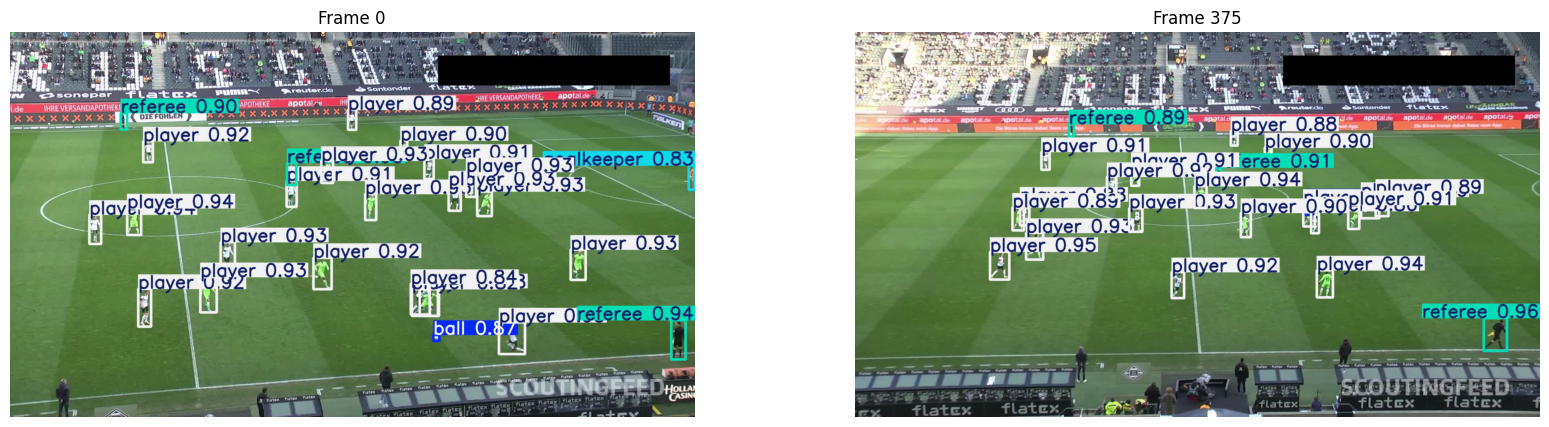

In [4]:
import cv2
import matplotlib.pyplot as plt

# Path to the output video
output_video_path = "/content/runs/detect/predict/test_video_1.avi"

# Open the video file
cap = cv2.VideoCapture(output_video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    frames_to_plot = 2  # Number of frames to plot
    interval = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) // frames_to_plot)  # Evenly spaced frames

    fig, axes = plt.subplots(1, frames_to_plot, figsize=(20, 5))

    for i in range(frames_to_plot):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)  # Move to the target frame
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            axes[i].imshow(frame)
            axes[i].axis("off")
            axes[i].set_title(f"Frame {i * interval}")
        else:
            print(f"Error reading frame {i * interval}")

    plt.show()

cap.release()
